In [1]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.4'
spark_version = 'spark-3.5.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ReadBestModel").getOrCreate()

In [7]:
from google.colab import drive
import tensorflow as tf
from keras import backend as K

# Define the custom metric
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

# Mount Google Drive
drive.mount('/content/drive')

# Load the model with custom objects
best_model = tf.keras.models.load_model(
    "/content/drive/My Drive/TeamFiles/best_neural_network.h5",
    custom_objects={"mse": mse}
)

print("✅ Best model reloaded successfully!")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Best model reloaded successfully!


In [8]:
import json

with open("/content/drive/My Drive/TeamFiles/best_hyperparameters.json", "r") as f:
    best_hyperparameters = json.load(f)

print("✅ Best hyperparameters reloaded successfully!")


✅ Best hyperparameters reloaded successfully!


In [9]:
# reload the cleaned data
from google.colab import drive
drive.mount('/content/drive')

# Load the Parquet file from Google Drive
file_path = "/content/drive/My Drive/TeamFiles/cleaned_data.parquet"
cleaned_df = spark.read.parquet(file_path)
cleaned_df.show(5)

# Show dataset info
print("✅ Cleaned data loaded successfully!")
print(cleaned_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+---+----------+----+-------------+----------+-----------------+-------------+---------------------------+----+-----+---+
|FSA|      DATE|HOUR|CUSTOMER_TYPE|PRICE_PLAN|TOTAL_CONSUMPTION|PREMISE_COUNT|AVG_CONSUMPTION_PER_PREMISE|YEAR|MONTH|DAY|
+---+----------+----+-------------+----------+-----------------+-------------+---------------------------+----+-----+---+
|M1V|2024-07-01|   1|    SGS <50kW|    Tiered|           3125.6|         1716|         1.8214452214452215|2024|    7|  1|
|L7M|2024-07-01|   1|    SGS <50kW|       TOU|           1563.8|          683|         2.2896046852122987|2024|    7|  1|
|L9W|2024-07-01|   1|  Residential|    Tiered|            925.0|         1232|         0.7508116883116883|2024|    7|  1|
|M2J|2024-07-01|   1|    SGS <50kW|    Tiered|            598.0|          267|         2.2397003745318353|2024|    7|  1|
|K2C|2024-07-01| 

In [10]:
# Apply the Same Transformations as Training
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

# Encode categorical columns
customer_type_indexer = StringIndexer(inputCol="CUSTOMER_TYPE", outputCol="CUSTOMER_TYPE_INDEX")
price_plan_indexer = StringIndexer(inputCol="PRICE_PLAN", outputCol="PRICE_PLAN_INDEX")

# Assemble feature columns (MUST MATCH THE TRAINING PROCESS)
feature_columns = [
    "HOUR", "PREMISE_COUNT", "AVG_CONSUMPTION_PER_PREMISE",
    "CUSTOMER_TYPE_INDEX", "PRICE_PLAN_INDEX", "YEAR", "MONTH", "DAY"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Normalize features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Create a pipeline
pipeline = Pipeline(stages=[customer_type_indexer, price_plan_indexer, assembler, scaler])

# Apply transformations
prepared_data = pipeline.fit(cleaned_df).transform(cleaned_df)

# Select only the necessary columns
final_data = prepared_data.select("scaled_features", "TOTAL_CONSUMPTION")

print("✅ Data successfully processed using Spark ML transformations!")

# Train-Test Split in Spark
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Convert Spark DataFrame to NumPy
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()


✅ Data successfully processed using Spark ML transformations!


In [11]:
# Check the shape of train and test datasets
print(f"✅ Training Data Shape: {train_pandas.shape}")
print(f"✅ Test Data Shape: {test_pandas.shape}")


✅ Training Data Shape: (3343689, 2)
✅ Test Data Shape: (836765, 2)


In [12]:
# Extract Features & Target Labels
import numpy as np

# Convert Spark DataFrame to NumPy
X_train = np.array(train_pandas["scaled_features"].tolist())
y_train = train_pandas["TOTAL_CONSUMPTION"]
X_test = np.array(test_pandas["scaled_features"].tolist())
y_test = test_pandas["TOTAL_CONSUMPTION"]

print(f"✅ X_train Shape: {X_train.shape}")
print(f"✅ X_test Shape: {X_test.shape}")

✅ X_train Shape: (3343689, 8)
✅ X_test Shape: (836765, 8)


In [13]:
# Make Predictions Using the Best Model
y_pred = best_model.predict(X_test)

# Convert predictions to a DataFrame for easy visualization
predictions_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred.flatten()})

# Show first few results
predictions_df.head()


26149/26149 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step


,Actual,Predicted
0,9.1,69.160255
1,133.0,199.032501
2,132.0,180.999115
3,196.6,209.339966
4,200.7,208.291977


In [15]:
# Evaluate the Model Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 39.03
Mean Squared Error (MSE): 14235.56
R² Score: 0.9997


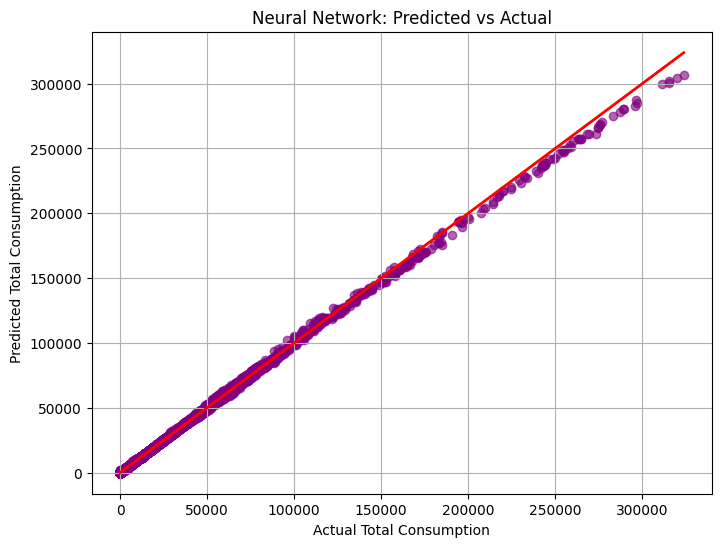

In [16]:
# Visualize Actual vs Predicted Values
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linewidth=2)
plt.title("Neural Network: Predicted vs Actual")
plt.xlabel("Actual Total Consumption")
plt.ylabel("Predicted Total Consumption")
plt.grid()
plt.show()


In [18]:
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 144)                 │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 240)                 │          34,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 48)                  │          11,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 240)                 │          11,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 176)                 │          42,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 208)                 │          36,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             209 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,867 (542.45 KB)

 Trainable params: 138,865 (542.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)